## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman3Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1
bias = 1 

## Dataset 


In [4]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1

In [5]:
X,Y = friedman3Dataset.friedman3_data(n_samples)

         X0        X1        X2        X3        X4         Y
0 -0.102997  0.286407 -0.848860  0.460798 -0.368319  0.552313
1  0.966699 -0.861384  1.202974 -0.554610  0.490027 -0.035982
2  1.015778 -0.519084 -0.420691 -0.611291  1.350791  0.167009
3  1.270657  1.630203 -1.403527  0.069608  1.729462  0.653570
4 -1.186841 -0.667184 -0.713756  0.120242 -1.508371 -1.376169


In [6]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [7]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [8]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.024897
0:	learn: 0.9901966	total: 60.6ms	remaining: 1m
1:	learn: 0.9806865	total: 61.2ms	remaining: 30.5s
2:	learn: 0.9707829	total: 61.8ms	remaining: 20.5s
3:	learn: 0.9614231	total: 62.2ms	remaining: 15.5s
4:	learn: 0.9517325	total: 62.6ms	remaining: 12.5s
5:	learn: 0.9432757	total: 63ms	remaining: 10.4s
6:	learn: 0.9345412	total: 63.7ms	remaining: 9.03s
7:	learn: 0.9255540	total: 64.4ms	remaining: 7.99s
8:	learn: 0.9177019	total: 64.9ms	remaining: 7.15s
9:	learn: 0.9096587	total: 65.4ms	remaining: 6.47s
10:	learn: 0.9008696	total: 65.9ms	remaining: 5.92s
11:	learn: 0.8916181	total: 66.4ms	remaining: 5.46s
12:	learn: 0.8829646	total: 66.7ms	remaining: 5.07s
13:	learn: 0.8739363	total: 67.1ms	remaining: 4.72s
14:	learn: 0.8674158	total: 67.4ms	remaining: 4.42s
15:	learn: 0.8585458	total: 67.8ms	remaining: 4.17s
16:	learn: 0.8508369	total: 68.1ms	remaining: 3.94s
17:	learn: 0.8435642	total: 68.6ms	remaining: 3.74s
18:	learn: 0.8362622	total: 69ms	remaining: 3.56s

In [9]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)
mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mae)

# ABC GAN Model

In [10]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

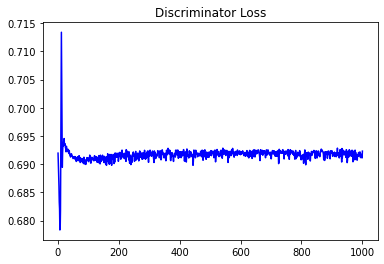

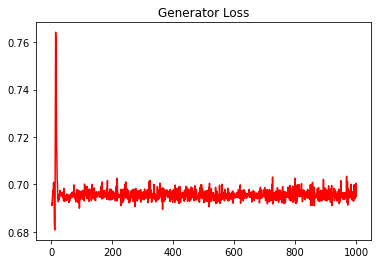

In [11]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [12]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MSE")
print(mean(ABC_GAN1_metrics[0]))

MSE
0.10833917264236582


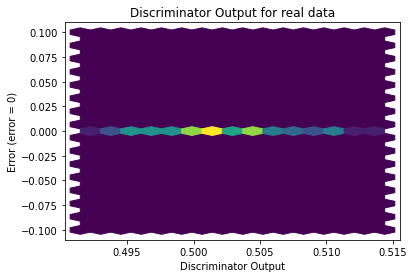

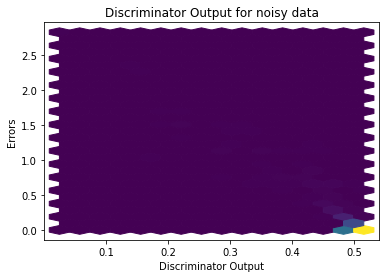

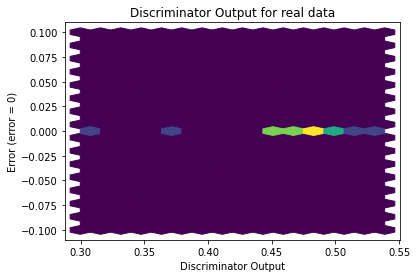

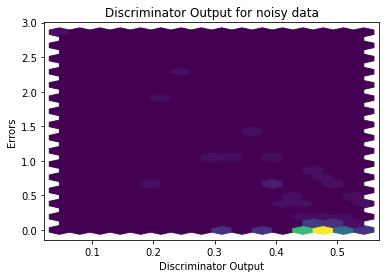

In [13]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [14]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


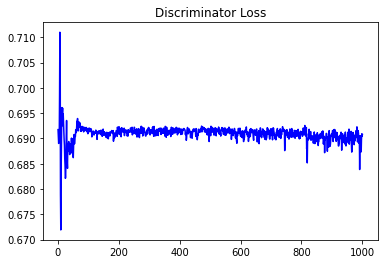

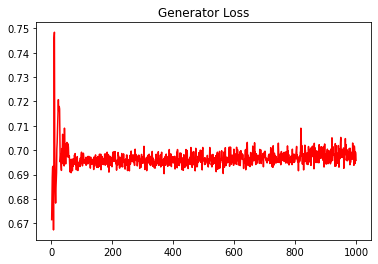

In [15]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [16]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MSE")
print(mean(ABC_GAN3_metrics[0]))

MSE
0.06474078771478989


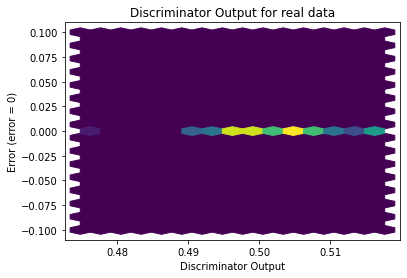

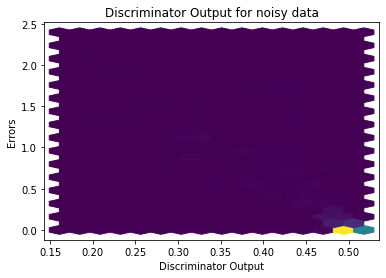

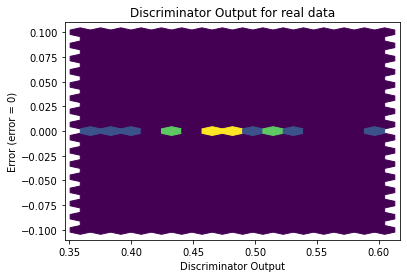

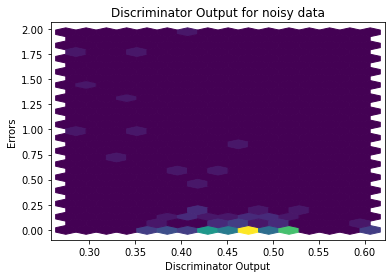

In [17]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [18]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.5465]], requires_grad=True)
